In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 128
learning_rate = 0.0005
num_epochs = 10

In [16]:
train_dataset = torchvision.datasets.MNIST(
root='./data',
train=True,
transform=transforms.ToTensor(),
download=True
)
test_dataset = torchvision.datasets.MNIST(
root='./data',
train=False,
transform=transforms.ToTensor(),
download=True
)
train_loader = torch.utils.data.DataLoader(
dataset=train_dataset,
batch_size=batch_size,
shuffle=True
)
test_loader = torch.utils.data.DataLoader(
dataset=test_dataset,
batch_size=batch_size,
shuffle=False
)

In [17]:
class ManualLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ManualLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weight matrices for concatenated input (x + h)
        concat_size = input_size + hidden_size

        self.W_f = nn.Linear(concat_size, hidden_size)
        self.W_i = nn.Linear(concat_size, hidden_size)
        self.W_c = nn.Linear(concat_size, hidden_size)
        self.W_o = nn.Linear(concat_size, hidden_size)

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat((x, h_prev), dim=1)

        f_t = torch.sigmoid(self.W_f(combined))
        i_t = torch.sigmoid(self.W_i(combined))
        c_tilde = torch.tanh(self.W_c(combined))
        c_t = f_t * c_prev + i_t * c_tilde
        o_t = torch.sigmoid(self.W_o(combined))
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


In [18]:
class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ManualLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = ManualLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)

        out = self.fc(h_t)
        return out


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ManualLSTMClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28, 28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/469], Loss: 0.9670
Epoch [1/10], Step [200/469], Loss: 0.5535
Epoch [1/10], Step [300/469], Loss: 0.5297
Epoch [1/10], Step [400/469], Loss: 0.3474
Epoch [2/10], Step [100/469], Loss: 0.2392
Epoch [2/10], Step [200/469], Loss: 0.3261
Epoch [2/10], Step [300/469], Loss: 0.3555
Epoch [2/10], Step [400/469], Loss: 0.2009
Epoch [3/10], Step [100/469], Loss: 0.1201
Epoch [3/10], Step [200/469], Loss: 0.1110
Epoch [3/10], Step [300/469], Loss: 0.1457
Epoch [3/10], Step [400/469], Loss: 0.0897
Epoch [4/10], Step [100/469], Loss: 0.1467
Epoch [4/10], Step [200/469], Loss: 0.1345
Epoch [4/10], Step [300/469], Loss: 0.1937
Epoch [4/10], Step [400/469], Loss: 0.1514
Epoch [5/10], Step [100/469], Loss: 0.1104
Epoch [5/10], Step [200/469], Loss: 0.1331
Epoch [5/10], Step [300/469], Loss: 0.1410
Epoch [5/10], Step [400/469], Loss: 0.1016
Epoch [6/10], Step [100/469], Loss: 0.1571
Epoch [6/10], Step [200/469], Loss: 0.1476
Epoch [6/10], Step [300/469], Loss: 0.1421
Epoch [6/10

In [24]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 97.70%


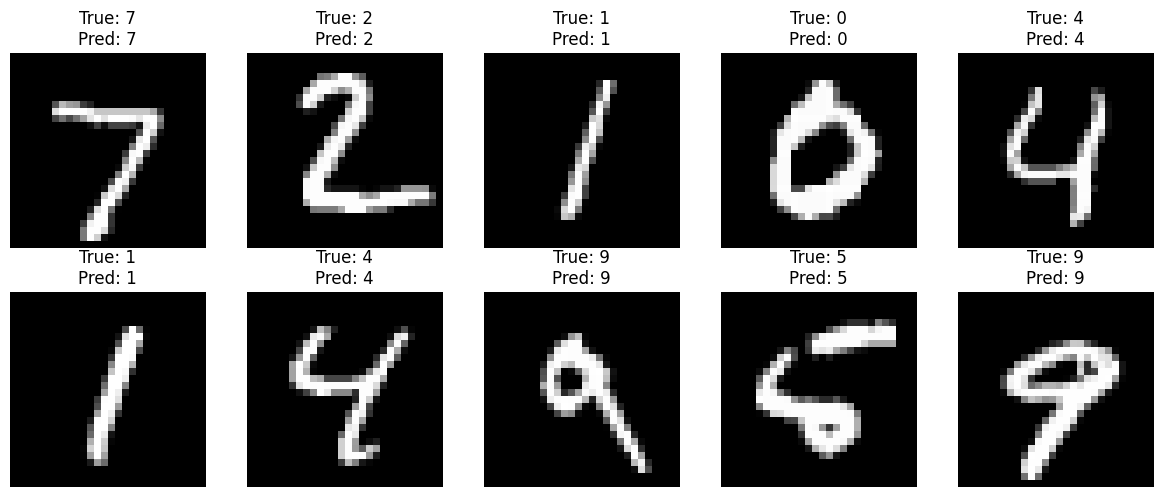

In [21]:
# Visualization
import matplotlib.pyplot as plt

model.eval()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = example_data.to(device)
example_targets = example_targets.to(device)
example_outputs = model(example_data.reshape(-1, 28, 28))
_, preds = torch.max(example_outputs.data, 1)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_data[i].cpu().squeeze(), cmap='gray')
    plt.title(f'True: {example_targets[i].item()}\nPred: {preds[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()
